In [ ]:
import torch
from torch import nn
import numpy as np
import os
class FacePredict(nn.Module):
    def __init__(self):
        """
        Initialize using a pretrained tf model
        """
        super().__init__()
        self.lstm = nn.LSTM(28, 60)
        self.dropout = nn.Dropout(p=0.7)
        self.dense = nn.Linear(60, 20)
        
    def forward(self, inputs):
        hid0, _ = self.lstm(inputs)
        hiddrop = self.dropout(hid0)
        return self.dense(hid0)
    
    def load_weights_tf(self):
        #get the weights from tf model
        with torch.no_grad():
            #reorder weights to convert from tf to torch
            wii, wic, wif, wio = np.split(weights[2][:28, :], 4, 1)
            whi, whc, whf, who = np.split(weights[2][28:, :], 4, 1)
            wih = np.concatenate((wii, wif, wic, wio), axis = 1)
            whh = np.concatenate((whi, whf, whc, who), axis = 1)

            self.lstm.weight_ih_l0.data = torch.from_numpy(wih).transpose(0,1)
            self.lstm.weight_hh_l0.data = torch.from_numpy(whh).transpose(0,1)
            self.lstm.bias_hh_l0.data = torch.from_numpy(weights[3])
            self.lstm.bias_ih_l0.data = torch.zeros((240))

            self.dense.weight.data = torch.from_numpy(weights[0].T)
            self.dense.bias.data = torch.from_numpy(weights[1])


In [ ]:
def get_audio_derivatives(audio):
    #calculate audio derivatives, return timestamps too
    audiodiff = audio[1:,:-1] - audio[:-1, :-1]
    times = audio[:, -1]
    return np.concatenate((audio[:-1, :-1], audiodiff[:, :]), axis=1), times

def shifted_time(i, times):
      if i >= 20:
        return times[i - 20]
      else:
        return times[0]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
person = 'trump'
dataset_name = {'obama':'nHREBzHqFTQ', 'trump':'xAAmF3H0-ek'}[person]

In [ ]:
audio_preprocessed = np.load(f'/content/drive/MyDrive/6869/{dataset_name}_audio.npy')
audio_data = get_audio_derivatives(audio_preprocessed)[0]
print(audio_data.shape)
audio_mean = audio_data.mean(axis = 0)
audio_std = audio_data.std(axis = 0)

(57190, 28)


In [ ]:
class FacePredictFineTune(FacePredict):
    def __init__(self, mean, std):
        super().__init__()
        self.dense_input = nn.Linear(28, 28, bias = False)
        self.dense_diff = nn.Linear(60, 20, bias = False)

        nn.init.zeros_(self.dense_input.weight)
        
        nn.init.xavier_uniform_(self.dense_diff.weight)
        
        self.bn = nn.BatchNorm1d(28) #not used
        self.mean = torch.from_numpy(mean).requires_grad_(False)
        self.std = torch.from_numpy(std).requires_grad_(False)

    def forward(self, inputs):
        #shape T*B*D (time*batch*num_feat)
        inputs_transformed = inputs# + self.dense_input(inputs)/10
        inputs_norm = (inputs_transformed - self.mean[None, None, :]) / self.std[None, None, :]
        hid0, _ = self.lstm(inputs_norm)
        hiddrop = self.dropout(hid0)
        return self.dense(hid0) # +self.dense_diff(hid0)

    def cuda(self):
        super().cuda()
        self.mean, self.std = self.mean.cuda(), self.std.cuda()

In [ ]:
model = FacePredictFineTune(audio_mean, audio_std)
model.load_state_dict(torch.load('/content/drive/MyDrive/6869/face predict'))
model.double()
model.cuda()
model.train()
#torch.save(fpf.state_dict(), 'face predict')

FacePredictFineTune(
  (lstm): LSTM(28, 60)
  (dropout): Dropout(p=0.7, inplace=False)
  (dense): Linear(in_features=60, out_features=20, bias=True)
  (dense_input): Linear(in_features=28, out_features=28, bias=False)
  (dense_diff): Linear(in_features=60, out_features=20, bias=False)
  (bn): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
video_data = np.load(f'/content/drive/MyDrive/6869/{dataset_name}_landmarks_frontalized.npy').reshape(-1, 25, 2)
video_lip_fiducials = video_data[:, 5:].reshape(-1, 40)
video_lip_fiducials = video_lip_fiducials[:, list(range(24)) + list(range(26,32)) + list(range(34,40))]
video_lip_fiducials.shape

(16947, 36)

In [ ]:
#crop and shift of video, in seconds
start_frame = {'obama': 303, 'trump': 12}[person]
end_frame = {'obama': 6103, 'trump': 16959}[person]
video_start = start_frame*100//30 #12
video_end = (end_frame - 1)*100//30 #inclusive 16958
video_shft = 20
video_start

40

In [ ]:
#preprocess video using pca
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
lip_features = pca.fit_transform(video_lip_fiducials)

#constructing differentiable inverse to pca
pca_mean = torch.from_numpy(pca.inverse_transform(np.zeros((1, 20)))).cuda().requires_grad_(False)
pca_inverse_mat = torch.from_numpy(pca.inverse_transform(np.eye(20))).cuda().requires_grad_(False) - pca_mean

def pca_inverse(coeffs): #pca inverse function
    return torch.matmul(coeffs, pca_inverse_mat) + pca_mean

#upsampling
from scipy.interpolate import interp1d
video_times = np.arange(start_frame, end_frame)/30
lips_interpolate = interp1d(video_times, lip_features, axis = 0)
audio_times = np.arange(video_start, video_end)/100
lips_upsampled = lips_interpolate(audio_times)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
class FacePredictDataset(Dataset):
    def __init__(self, inputs, outputs, predict_delay, output_begin, num_cuts = 18):
        #temporally inputs[output_begin] matches with outputs[0]
        #in rnn match inputs[output_begin + predict_delay] with outputs[0] 

        #crop outputs
        output_length = len(outputs)
        crop_len = output_length // num_cuts
        self.outputs = [outputs[crop_len*n:crop_len*(n+1)] for n in range(num_cuts)]

        #find matching parts of inputs
        self.inputs = [inputs[crop_len*n + output_begin: crop_len*(n+1) + output_begin + predict_delay] for n in range(num_cuts)]
        self.len = num_cuts
        self.crop_len = crop_len

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return [self.inputs[idx], self.outputs[idx], self.crop_len * idx]

In [ ]:
#create datasets
num_crops = 1700
data = FacePredictDataset(audio_data, lips_upsampled, video_shft, video_start, num_crops)
train_data, test_data = torch.utils.data.random_split(data, [1400, 300])
test_dataloader = DataLoader(test_data, batch_size=20, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True)

In [ ]:
from torch import optim

inner_lip_pairs = ((13, 19), (14, 18), (15, 17))
def inner_lip_distance(coeffs):
    landmarks = pca_inverse(coeffs)
    return sum([torch.square(landmarks[:, :, u] - landmarks[:, :, l]) for u, l in inner_lip_pairs])

def volume(audio_features):
    return audio_feature[13]

def hyperbolic_loss(y1, y2):
    return torch.sum(y1/y2 + y2/y1) / y1.numel()

def logarithmic_loss(y1, y2):
    return l1(torch.log(y1), torch.log(y2)) * 10

def distance_loss(y1, y2):
    return l1(distance_matrix(y1), distance_matrix(y2)) / 100

def distance_temp_loss(y1, y2):
    return l1(distance_temp_matrix(y1), distance_temp_matrix(y2)) / 100

def distance_matrix(y):
    #y B*T*PCA => (B*T)*PCA =>dist (B*T)*(B*T)
    mat_y = y.reshape(-1, y.shape[-1])
    pairwise = torch.mm(mat_y, mat_y.transpose(0,1))
    lens = torch.diag(pairwise)
    return pairwise - lens[:, None] - lens[None, :]

def distance_temp_matrix(y):
    pairwise = torch.bmm(y, y.transpose(2,1))
    lens = torch.diagonal(pairwise, dim1=1, dim2=2)
    return pairwise - lens[:, :, None] - lens[:, None, :]

def delay_loss(preds, y, loss, delay):
    y_pred = preds[:, delay:, :] #remove_delay
    return distance_temp_loss(y_pred, y)
    # distance_loss(y_pred, y) 
    # hyperbolic_loss(inner_lip_distance(y_pred), inner_lip_distance(y)) * 10 
    # loss(y_pred, y)


l1 = nn.L1Loss()
loss = nn.MSELoss()



















  0%|          | 0/300 [00:00<?, ?it/s]

















  0%|          | 1/300 [00:00<00:39,  7.66it/s]

















  1%|          | 2/300 [00:00<00:37,  8.00it/s]

epoch:  0
training loss: 1.2553738023718812
validation loss: 1.2655103655333968




















  1%|          | 3/300 [00:00<00:35,  8.26it/s]

















  1%|▏         | 4/300 [00:00<00:34,  8.66it/s]

















  2%|▏         | 5/300 [00:00<00:33,  8.89it/s]

















  2%|▏         | 6/300 [00:00<00:32,  9.11it/s]

















  2%|▏         | 7/300 [00:00<00:31,  9.21it/s]

















  3%|▎         | 8/300 [00:00<00:31,  9.34it/s]

















  3%|▎         | 9/300 [00:00<00:30,  9.47it/s]

















  3%|▎         | 10/300 [00:01<00:30,  9.37it/s]

















  4%|▎         | 11/300 [00:01<00:30,  9.44it/s]

















  4%|▍         | 12/300 [00:01<00:30,  9.44it/s]

















  4%|▍         | 13/300 [00:01<00:30,  9.55it/s]

















  5%|▍         | 14/300 [00:01<00:29,  9.55it/s]

















  5%|▌         | 15/300 [00:01<00:30,  9.45it/s]

















  5%|▌         | 16/300 [00:01<00:31,  8.94it/s]

















  6%|▌         | 17/300 [00:01<00:31,  9.03it/s]

epoch:  15
training loss: 1.1852128922256937
validation loss: 1.2482721110980468




















  6%|▌         | 18/300 [00:01<00:30,  9.14it/s]

















  6%|▋         | 19/300 [00:02<00:30,  9.30it/s]

















  7%|▋         | 20/300 [00:02<00:30,  9.33it/s]

















  7%|▋         | 21/300 [00:02<00:29,  9.37it/s]

















  7%|▋         | 22/300 [00:02<00:29,  9.42it/s]

















  8%|▊         | 23/300 [00:02<00:29,  9.40it/s]

















  8%|▊         | 24/300 [00:02<00:29,  9.51it/s]

















  8%|▊         | 25/300 [00:02<00:28,  9.63it/s]

















  9%|▊         | 26/300 [00:02<00:29,  9.42it/s]

















  9%|▉         | 27/300 [00:02<00:28,  9.46it/s]

















  9%|▉         | 28/300 [00:03<00:28,  9.50it/s]

















 10%|▉         | 29/300 [00:03<00:28,  9.47it/s]

















 10%|█         | 30/300 [00:03<00:28,  9.51it/s]

















 10%|█         | 31/300 [00:03<00:30,  8.78it/s]

















 11%|█         | 32/300 [00:03<00:29,  9.02it/s]

epoch:  30
training loss: 1.1797040370608534
validation loss: 1.2469385686813947




















 11%|█         | 33/300 [00:03<00:29,  9.13it/s]

















 11%|█▏        | 34/300 [00:03<00:28,  9.33it/s]

















 12%|█▏        | 35/300 [00:03<00:28,  9.45it/s]

















 12%|█▏        | 36/300 [00:03<00:27,  9.49it/s]

















 12%|█▏        | 37/300 [00:03<00:27,  9.46it/s]

















 13%|█▎        | 38/300 [00:04<00:27,  9.45it/s]

















 13%|█▎        | 39/300 [00:04<00:27,  9.51it/s]

















 13%|█▎        | 40/300 [00:04<00:27,  9.56it/s]

















 14%|█▎        | 41/300 [00:04<00:27,  9.50it/s]

















 14%|█▍        | 42/300 [00:04<00:26,  9.56it/s]

















 14%|█▍        | 43/300 [00:04<00:26,  9.54it/s]

















 15%|█▍        | 44/300 [00:04<00:26,  9.55it/s]

















 15%|█▌        | 45/300 [00:04<00:26,  9.56it/s]

















 15%|█▌        | 46/300 [00:04<00:28,  8.98it/s]

















 16%|█▌        | 47/300 [00:05<00:27,  9.06it/s]

epoch:  45
training loss: 1.1779248637679092
validation loss: 1.2471723032508046




















 16%|█▌        | 48/300 [00:05<00:27,  9.12it/s]

















 16%|█▋        | 49/300 [00:05<00:27,  9.29it/s]

















 17%|█▋        | 50/300 [00:05<00:26,  9.40it/s]

















 17%|█▋        | 51/300 [00:05<00:26,  9.42it/s]

















 17%|█▋        | 52/300 [00:05<00:26,  9.39it/s]

















 18%|█▊        | 53/300 [00:05<00:26,  9.38it/s]

















 18%|█▊        | 54/300 [00:05<00:26,  9.46it/s]

















 18%|█▊        | 55/300 [00:05<00:25,  9.50it/s]

















 19%|█▊        | 56/300 [00:05<00:25,  9.53it/s]

















 19%|█▉        | 57/300 [00:06<00:25,  9.48it/s]

















 19%|█▉        | 58/300 [00:06<00:25,  9.45it/s]

















 20%|█▉        | 59/300 [00:06<00:25,  9.51it/s]

















 20%|██        | 60/300 [00:06<00:25,  9.44it/s]

















 20%|██        | 61/300 [00:06<00:26,  8.88it/s]

















 21%|██        | 62/300 [00:06<00:26,  9.00it/s]

epoch:  60
training loss: 1.1740402931767282
validation loss: 1.230887354327212




















 21%|██        | 63/300 [00:06<00:26,  9.05it/s]

















 21%|██▏       | 64/300 [00:06<00:25,  9.20it/s]

















 22%|██▏       | 65/300 [00:06<00:25,  9.34it/s]

















 22%|██▏       | 66/300 [00:07<00:24,  9.37it/s]

















 22%|██▏       | 67/300 [00:07<00:24,  9.42it/s]

















 23%|██▎       | 68/300 [00:07<00:24,  9.52it/s]

















 23%|██▎       | 69/300 [00:07<00:24,  9.53it/s]

















 23%|██▎       | 70/300 [00:07<00:24,  9.58it/s]

















 24%|██▎       | 71/300 [00:07<00:24,  9.54it/s]

















 24%|██▍       | 72/300 [00:07<00:23,  9.64it/s]

















 24%|██▍       | 73/300 [00:07<00:23,  9.52it/s]

















 25%|██▍       | 74/300 [00:07<00:23,  9.54it/s]

















 25%|██▌       | 75/300 [00:08<00:23,  9.55it/s]

















 25%|██▌       | 76/300 [00:08<00:25,  8.85it/s]

















 26%|██▌       | 77/300 [00:08<00:24,  9.04it/s]

epoch:  75
training loss: 1.1690281516280454
validation loss: 1.2287510037867877




















 26%|██▌       | 78/300 [00:08<00:24,  9.04it/s]

















 26%|██▋       | 79/300 [00:08<00:24,  9.12it/s]

















 27%|██▋       | 80/300 [00:08<00:23,  9.34it/s]

















 27%|██▋       | 81/300 [00:08<00:23,  9.45it/s]

















 27%|██▋       | 82/300 [00:08<00:22,  9.52it/s]

















 28%|██▊       | 83/300 [00:08<00:22,  9.51it/s]

















 28%|██▊       | 84/300 [00:08<00:22,  9.59it/s]

















 28%|██▊       | 85/300 [00:09<00:22,  9.62it/s]

















 29%|██▊       | 86/300 [00:09<00:22,  9.46it/s]

















 29%|██▉       | 87/300 [00:09<00:22,  9.51it/s]

















 29%|██▉       | 88/300 [00:09<00:22,  9.58it/s]

















 30%|██▉       | 89/300 [00:09<00:21,  9.61it/s]

















 30%|███       | 90/300 [00:09<00:21,  9.62it/s]

















 30%|███       | 91/300 [00:09<00:23,  8.99it/s]

















 31%|███       | 92/300 [00:09<00:22,  9.06it/s]

epoch:  90
training loss: 1.1646721899378947
validation loss: 1.2343508706018906




















 31%|███       | 93/300 [00:09<00:22,  9.20it/s]

















 31%|███▏      | 94/300 [00:10<00:22,  9.31it/s]

















 32%|███▏      | 95/300 [00:10<00:21,  9.32it/s]

















 32%|███▏      | 96/300 [00:10<00:21,  9.29it/s]

















 32%|███▏      | 97/300 [00:10<00:21,  9.34it/s]

















 33%|███▎      | 98/300 [00:10<00:21,  9.38it/s]

















 33%|███▎      | 99/300 [00:10<00:21,  9.44it/s]

















 33%|███▎      | 100/300 [00:10<00:21,  9.41it/s]

















 34%|███▎      | 101/300 [00:10<00:21,  9.35it/s]

















 34%|███▍      | 102/300 [00:10<00:21,  9.40it/s]

















 34%|███▍      | 103/300 [00:11<00:20,  9.41it/s]

















 35%|███▍      | 104/300 [00:11<00:20,  9.45it/s]

















 35%|███▌      | 105/300 [00:11<00:20,  9.32it/s]

















 35%|███▌      | 106/300 [00:11<00:21,  8.83it/s]

















 36%|███▌      | 107/300 [00:11<00:21,  8.92it/s]

epoch:  105
training loss: 1.165862511038492
validation loss: 1.2375379140170444




















 36%|███▌      | 108/300 [00:11<00:21,  8.95it/s]

















 36%|███▋      | 109/300 [00:11<00:21,  9.03it/s]

















 37%|███▋      | 110/300 [00:11<00:20,  9.13it/s]

















 37%|███▋      | 111/300 [00:11<00:20,  9.35it/s]

















 37%|███▋      | 112/300 [00:12<00:20,  9.37it/s]

















 38%|███▊      | 113/300 [00:12<00:19,  9.45it/s]

















 38%|███▊      | 114/300 [00:12<00:19,  9.41it/s]

















 38%|███▊      | 115/300 [00:12<00:19,  9.42it/s]

















 39%|███▊      | 116/300 [00:12<00:19,  9.39it/s]

















 39%|███▉      | 117/300 [00:12<00:19,  9.41it/s]

















 39%|███▉      | 118/300 [00:12<00:19,  9.47it/s]

















 40%|███▉      | 119/300 [00:12<00:19,  9.39it/s]

















 40%|████      | 120/300 [00:12<00:19,  9.44it/s]

















 40%|████      | 121/300 [00:12<00:20,  8.95it/s]

















 41%|████      | 122/300 [00:13<00:19,  9.13

epoch:  120
training loss: 1.1600160031787685
validation loss: 1.2292637266474238




















 41%|████      | 123/300 [00:13<00:19,  9.10it/s]

















 41%|████▏     | 124/300 [00:13<00:19,  9.22it/s]

















 42%|████▏     | 125/300 [00:13<00:18,  9.22it/s]

















 42%|████▏     | 126/300 [00:13<00:18,  9.42it/s]

















 42%|████▏     | 127/300 [00:13<00:18,  9.45it/s]

















 43%|████▎     | 128/300 [00:13<00:18,  9.50it/s]

















 43%|████▎     | 129/300 [00:13<00:18,  9.25it/s]

















 43%|████▎     | 130/300 [00:13<00:18,  9.38it/s]

















 44%|████▎     | 131/300 [00:14<00:17,  9.42it/s]

















 44%|████▍     | 132/300 [00:14<00:17,  9.44it/s]

















 44%|████▍     | 133/300 [00:14<00:17,  9.39it/s]

















 45%|████▍     | 134/300 [00:14<00:17,  9.45it/s]

















 45%|████▌     | 135/300 [00:14<00:17,  9.43it/s]

















 45%|████▌     | 136/300 [00:14<00:18,  8.90it/s]

















 46%|████▌     | 137/300 [00:14<00:18,  8.96

epoch:  135
training loss: 1.159102884044745
validation loss: 1.2239527480856969




















 46%|████▌     | 138/300 [00:14<00:18,  8.87it/s]

















 46%|████▋     | 139/300 [00:14<00:17,  9.04it/s]

















 47%|████▋     | 140/300 [00:15<00:17,  9.13it/s]

















 47%|████▋     | 141/300 [00:15<00:17,  9.11it/s]

















 47%|████▋     | 142/300 [00:15<00:17,  9.15it/s]

















 48%|████▊     | 143/300 [00:15<00:16,  9.27it/s]

















 48%|████▊     | 144/300 [00:15<00:16,  9.27it/s]

















 48%|████▊     | 145/300 [00:15<00:16,  9.39it/s]

















 49%|████▊     | 146/300 [00:15<00:16,  9.44it/s]

















 49%|████▉     | 147/300 [00:15<00:16,  9.54it/s]

















 49%|████▉     | 148/300 [00:15<00:15,  9.54it/s]

















 50%|████▉     | 149/300 [00:15<00:15,  9.52it/s]

















 50%|█████     | 150/300 [00:16<00:15,  9.46it/s]

















 50%|█████     | 151/300 [00:16<00:17,  8.64it/s]

















 51%|█████     | 152/300 [00:16<00:16,  8.71

epoch:  150
training loss: 1.159222168544631
validation loss: 1.2186626065748551




















 51%|█████     | 153/300 [00:16<00:16,  8.87it/s]

















 51%|█████▏    | 154/300 [00:16<00:16,  9.02it/s]

















 52%|█████▏    | 155/300 [00:16<00:15,  9.14it/s]

















 52%|█████▏    | 156/300 [00:16<00:15,  9.16it/s]

















 52%|█████▏    | 157/300 [00:16<00:15,  9.24it/s]

















 53%|█████▎    | 158/300 [00:16<00:15,  9.38it/s]

















 53%|█████▎    | 159/300 [00:17<00:14,  9.46it/s]

















 53%|█████▎    | 160/300 [00:17<00:14,  9.53it/s]

















 54%|█████▎    | 161/300 [00:17<00:15,  9.26it/s]

















 54%|█████▍    | 162/300 [00:17<00:14,  9.28it/s]

















 54%|█████▍    | 163/300 [00:17<00:14,  9.23it/s]

















 55%|█████▍    | 164/300 [00:17<00:14,  9.30it/s]

















 55%|█████▌    | 165/300 [00:17<00:14,  9.42it/s]

















 55%|█████▌    | 166/300 [00:17<00:15,  8.90it/s]

















 56%|█████▌    | 167/300 [00:17<00:14,  8.90

epoch:  165
training loss: 1.1610451495573701
validation loss: 1.23389485098728




















 56%|█████▌    | 168/300 [00:18<00:14,  8.95it/s]

















 56%|█████▋    | 169/300 [00:18<00:14,  9.02it/s]

















 57%|█████▋    | 170/300 [00:18<00:14,  9.03it/s]

















 57%|█████▋    | 171/300 [00:18<00:14,  9.06it/s]

















 57%|█████▋    | 172/300 [00:18<00:13,  9.19it/s]

















 58%|█████▊    | 173/300 [00:18<00:13,  9.19it/s]

















 58%|█████▊    | 174/300 [00:18<00:13,  9.32it/s]

















 58%|█████▊    | 175/300 [00:18<00:13,  9.34it/s]

















 59%|█████▊    | 176/300 [00:18<00:13,  9.41it/s]

















 59%|█████▉    | 177/300 [00:19<00:13,  9.36it/s]

















 59%|█████▉    | 178/300 [00:19<00:13,  9.35it/s]

















 60%|█████▉    | 179/300 [00:19<00:13,  9.30it/s]

















 60%|██████    | 180/300 [00:19<00:13,  9.21it/s]

















 60%|██████    | 181/300 [00:19<00:13,  8.77it/s]

















 61%|██████    | 182/300 [00:19<00:13,  8.84

epoch:  180
training loss: 1.15495438295852
validation loss: 1.2176133289925495




















 61%|██████    | 183/300 [00:19<00:13,  8.93it/s]

















 61%|██████▏   | 184/300 [00:19<00:12,  9.07it/s]

















 62%|██████▏   | 185/300 [00:19<00:12,  9.17it/s]

















 62%|██████▏   | 186/300 [00:20<00:12,  9.15it/s]

















 62%|██████▏   | 187/300 [00:20<00:12,  9.23it/s]

















 63%|██████▎   | 188/300 [00:20<00:12,  9.27it/s]

















 63%|██████▎   | 189/300 [00:20<00:11,  9.28it/s]

















 63%|██████▎   | 190/300 [00:20<00:11,  9.37it/s]

















 64%|██████▎   | 191/300 [00:20<00:11,  9.33it/s]

















 64%|██████▍   | 192/300 [00:20<00:11,  9.41it/s]

















 64%|██████▍   | 193/300 [00:20<00:11,  9.57it/s]

















 65%|██████▍   | 194/300 [00:20<00:11,  9.58it/s]

















 65%|██████▌   | 195/300 [00:20<00:10,  9.56it/s]

















 65%|██████▌   | 196/300 [00:21<00:11,  8.95it/s]

















 66%|██████▌   | 197/300 [00:21<00:11,  9.06

epoch:  195
training loss: 1.154328430588633
validation loss: 1.231239469911693




















 66%|██████▌   | 198/300 [00:21<00:11,  9.09it/s]

















 66%|██████▋   | 199/300 [00:21<00:11,  9.11it/s]

















 67%|██████▋   | 200/300 [00:21<00:10,  9.16it/s]

















 67%|██████▋   | 201/300 [00:21<00:10,  9.24it/s]

















 67%|██████▋   | 202/300 [00:21<00:10,  9.27it/s]

















 68%|██████▊   | 203/300 [00:21<00:10,  9.23it/s]

















 68%|██████▊   | 204/300 [00:21<00:10,  9.22it/s]

















 68%|██████▊   | 205/300 [00:22<00:10,  9.23it/s]

















 69%|██████▊   | 206/300 [00:22<00:10,  9.25it/s]

















 69%|██████▉   | 207/300 [00:22<00:10,  9.22it/s]

















 69%|██████▉   | 208/300 [00:22<00:09,  9.28it/s]

















 70%|██████▉   | 209/300 [00:22<00:09,  9.32it/s]

















 70%|███████   | 210/300 [00:22<00:09,  9.21it/s]

















 70%|███████   | 211/300 [00:22<00:10,  8.64it/s]

















 71%|███████   | 212/300 [00:22<00:09,  8.83

epoch:  210
training loss: 1.1559333046466354
validation loss: 1.2271131929334798




















 71%|███████   | 213/300 [00:22<00:09,  8.88it/s]

















 71%|███████▏  | 214/300 [00:23<00:09,  9.01it/s]

















 72%|███████▏  | 215/300 [00:23<00:09,  9.09it/s]

















 72%|███████▏  | 216/300 [00:23<00:09,  9.16it/s]

















 72%|███████▏  | 217/300 [00:23<00:09,  9.06it/s]

















 73%|███████▎  | 218/300 [00:23<00:09,  9.06it/s]

















 73%|███████▎  | 219/300 [00:23<00:08,  9.17it/s]

















 73%|███████▎  | 220/300 [00:23<00:08,  9.23it/s]

















 74%|███████▎  | 221/300 [00:23<00:08,  9.22it/s]

















 74%|███████▍  | 222/300 [00:23<00:08,  9.28it/s]

















 74%|███████▍  | 223/300 [00:24<00:08,  8.91it/s]

















 75%|███████▍  | 224/300 [00:24<00:08,  9.15it/s]

















 75%|███████▌  | 225/300 [00:24<00:08,  9.32it/s]

















 75%|███████▌  | 226/300 [00:24<00:08,  8.70it/s]

















 76%|███████▌  | 227/300 [00:24<00:08,  8.86

epoch:  225
training loss: 1.1530383492369005
validation loss: 1.2291079615239284




















 76%|███████▌  | 228/300 [00:24<00:08,  8.92it/s]

















 76%|███████▋  | 229/300 [00:24<00:07,  9.08it/s]

















 77%|███████▋  | 230/300 [00:24<00:07,  8.97it/s]

















 77%|███████▋  | 231/300 [00:24<00:07,  9.17it/s]

















 77%|███████▋  | 232/300 [00:25<00:07,  9.24it/s]

















 78%|███████▊  | 233/300 [00:25<00:07,  9.29it/s]

















 78%|███████▊  | 234/300 [00:25<00:07,  9.31it/s]

















 78%|███████▊  | 235/300 [00:25<00:07,  9.09it/s]

















 79%|███████▊  | 236/300 [00:25<00:06,  9.23it/s]

















 79%|███████▉  | 237/300 [00:25<00:06,  9.28it/s]

















 79%|███████▉  | 238/300 [00:25<00:06,  9.30it/s]

















 80%|███████▉  | 239/300 [00:25<00:06,  9.32it/s]

















 80%|████████  | 240/300 [00:25<00:06,  9.36it/s]

















 80%|████████  | 241/300 [00:26<00:06,  8.68it/s]

















 81%|████████  | 242/300 [00:26<00:06,  8.83

epoch:  240
training loss: 1.1523611457503653
validation loss: 1.2303153278000494




















 81%|████████  | 243/300 [00:26<00:06,  8.88it/s]

















 81%|████████▏ | 244/300 [00:26<00:06,  8.99it/s]

















 82%|████████▏ | 245/300 [00:26<00:06,  9.09it/s]

















 82%|████████▏ | 246/300 [00:26<00:05,  9.05it/s]

















 82%|████████▏ | 247/300 [00:26<00:05,  9.11it/s]

















 83%|████████▎ | 248/300 [00:26<00:05,  9.12it/s]

















 83%|████████▎ | 249/300 [00:26<00:05,  9.21it/s]

















 83%|████████▎ | 250/300 [00:27<00:05,  9.23it/s]

















 84%|████████▎ | 251/300 [00:27<00:05,  9.25it/s]

















 84%|████████▍ | 252/300 [00:27<00:05,  9.30it/s]

















 84%|████████▍ | 253/300 [00:27<00:05,  9.22it/s]

















 85%|████████▍ | 254/300 [00:27<00:05,  9.04it/s]

















 85%|████████▌ | 255/300 [00:27<00:04,  9.12it/s]

















 85%|████████▌ | 256/300 [00:27<00:05,  8.60it/s]

















 86%|████████▌ | 257/300 [00:27<00:04,  8.71

epoch:  255
training loss: 1.1501406366735938
validation loss: 1.2252167365400113




















 86%|████████▌ | 258/300 [00:27<00:04,  8.63it/s]

















 86%|████████▋ | 259/300 [00:28<00:04,  8.82it/s]

















 87%|████████▋ | 260/300 [00:28<00:04,  8.91it/s]

















 87%|████████▋ | 261/300 [00:28<00:04,  9.02it/s]

















 87%|████████▋ | 262/300 [00:28<00:04,  9.10it/s]

















 88%|████████▊ | 263/300 [00:28<00:04,  8.95it/s]

















 88%|████████▊ | 264/300 [00:28<00:04,  8.98it/s]

















 88%|████████▊ | 265/300 [00:28<00:03,  9.11it/s]

















 89%|████████▊ | 266/300 [00:28<00:03,  9.14it/s]

















 89%|████████▉ | 267/300 [00:28<00:03,  9.25it/s]

















 89%|████████▉ | 268/300 [00:29<00:03,  9.26it/s]

















 90%|████████▉ | 269/300 [00:29<00:03,  9.32it/s]

















 90%|█████████ | 270/300 [00:29<00:03,  9.18it/s]

















 90%|█████████ | 271/300 [00:29<00:03,  8.75it/s]

















 91%|█████████ | 272/300 [00:29<00:03,  8.78

epoch:  270
training loss: 1.1512427528469906
validation loss: 1.22246482448736




















 91%|█████████ | 273/300 [00:29<00:03,  8.87it/s]

















 91%|█████████▏| 274/300 [00:29<00:02,  9.05it/s]

















 92%|█████████▏| 275/300 [00:29<00:02,  9.21it/s]

















 92%|█████████▏| 276/300 [00:29<00:02,  9.25it/s]

















 92%|█████████▏| 277/300 [00:30<00:02,  9.27it/s]

















 93%|█████████▎| 278/300 [00:30<00:02,  9.29it/s]

















 93%|█████████▎| 279/300 [00:30<00:02,  9.33it/s]

















 93%|█████████▎| 280/300 [00:30<00:02,  9.24it/s]

















 94%|█████████▎| 281/300 [00:30<00:02,  9.10it/s]

















 94%|█████████▍| 282/300 [00:30<00:01,  9.13it/s]

















 94%|█████████▍| 283/300 [00:30<00:01,  9.10it/s]

















 95%|█████████▍| 284/300 [00:30<00:01,  9.21it/s]

















 95%|█████████▌| 285/300 [00:30<00:01,  9.28it/s]

















 95%|█████████▌| 286/300 [00:31<00:01,  8.80it/s]

















 96%|█████████▌| 287/300 [00:31<00:01,  8.90

epoch:  285
training loss: 1.151692869357731
validation loss: 1.2297384760893288




















 96%|█████████▌| 288/300 [00:31<00:01,  8.99it/s]

















 96%|█████████▋| 289/300 [00:31<00:01,  9.07it/s]

















 97%|█████████▋| 290/300 [00:31<00:01,  9.10it/s]

















 97%|█████████▋| 291/300 [00:31<00:00,  9.23it/s]

















 97%|█████████▋| 292/300 [00:31<00:00,  9.23it/s]

















 98%|█████████▊| 293/300 [00:31<00:00,  9.25it/s]

















 98%|█████████▊| 294/300 [00:31<00:00,  9.32it/s]

















 98%|█████████▊| 295/300 [00:31<00:00,  9.32it/s]

















 99%|█████████▊| 296/300 [00:32<00:00,  9.25it/s]

















 99%|█████████▉| 297/300 [00:32<00:00,  9.30it/s]

















 99%|█████████▉| 298/300 [00:32<00:00,  9.33it/s]

















100%|█████████▉| 299/300 [00:32<00:00,  9.25it/s]

















100%|██████████| 300/300 [00:32<00:00,  9.22it/s]


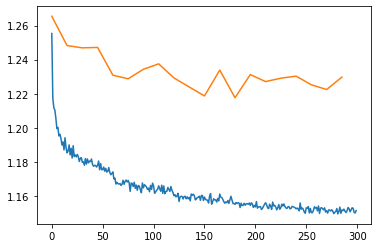

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, gamma=0.5, milestones=[60,120,180,240])
    n_epochs = 300

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(n_epochs)):            
        model.train()
        l_tot = 0
        num_batch = 0
        for X, y, _ in train_dataloader:
            X, y = X.cuda(), y.cuda()
            preds = model(X.double())
            l = delay_loss(preds, y, loss, video_shft)
            #print('training loss:', l)
            l_tot += l.item()
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            num_batch += 1
        scheduler.step()
        train_losses.append(l_tot/num_batch)   
        
        if epoch % (n_epochs//20) == 0:   
            model.eval()         
            l_val_tot = 0
            num_val_batch = 0
            for X_val, y_val, _ in test_dataloader:
                X_val, y_val = X_val.cuda(), y_val.cuda()
                preds_val = model(X_val.double())
                l_val = delay_loss(preds_val, y_val, loss, video_shft)
                l_val_tot += l_val.item()
                num_val_batch += 1

            val_losses.append(l_val_tot/num_val_batch)    
            #scheduler.step(l_val_tot/num_val_batch)

            print('epoch: ', epoch)
            print('training loss:', l_tot/num_batch)   
            print('validation loss:', l_val_tot/num_val_batch)
 
finally:
    fig, ax = plt.subplots()
    ax.plot(train_losses)
    ax.plot(list(range(0, len(val_losses) * (n_epochs//20), (n_epochs//20))), val_losses)
    plt.savefig(f'losses_{n_epochs}.png')            

In [ ]:
model.eval()
all_data = FacePredictDataset(audio_data, lips_upsampled, video_shft, video_start, 1)
test_dataloader = DataLoader(all_data, batch_size = 1)
#test_dataloader = DataLoader(test_data, batch_size=300, shuffle=True)
X_val, y_val, val_starts = test_dataloader.__iter__().next()
X_val, y_val = X_val.cuda(), y_val.cuda()
preds_val = model(X_val.double())
sample_pred = preds_val.detach().cpu().numpy()[:, video_shft:].reshape(-1, 20)
sample_lips = pca.inverse_transform(sample_pred)
true_lips = pca.inverse_transform(y_val.cpu().reshape(-1, 20))
print((val_starts)*30/100 + 12)
print(sample_pred.shape)

tensor([12.])
(56486, 20)


In [ ]:
#downsample predictions to 30 fps
preds_timess = [np.arange(video_start + val_st, video_start + val_st + all_data.crop_len) / 100 for val_st in val_starts]
downsample_timess = [np.arange(int(min(preds_t) * 30) + 1, int(max(preds_t) * 30)) / 30 for preds_t in preds_timess]
preds_times = np.concatenate(preds_timess)
downsample_times = np.concatenate(downsample_timess)

print(preds_times.shape, sample_lips.shape)
preds_interpolate = interp1d(preds_times, sample_lips, axis = 0)
downsample_preds = preds_interpolate(downsample_times)

true_interpolate = interp1d(preds_times, true_lips, axis = 0)
downsample_true = true_interpolate(downsample_times)

print(min(downsample_times)*30, max(downsample_times)*30)
print(downsample_preds.shape)

(56486,) (56486, 36)
13.0 16956.0
(16944, 36)


In [ ]:
np.save('/content/drive/MyDrive/6869/sample_lips', sample_lips)
np.save('/content/drive/MyDrive/6869/downsample_preds', downsample_preds)
np.save('/content/drive/MyDrive/6869/downsample_true', downsample_true)
np.save('/content/drive/MyDrive/6869/downsample_times', downsample_times)

import pandas as pd
pd.DataFrame(sample_lips).to_csv('/content/drive/MyDrive/6869/sample_lips.csv', sep=' ', index=False, header=False)
pd.DataFrame(downsample_preds).to_csv('/content/drive/MyDrive/6869/downsample_preds.csv', sep=' ', index=False, header=False)